<a href="https://www.kaggle.com/sdysch/eda-congestion-spikes-and-naive-predictions?scriptVersionId=89346557" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt

In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv')
df_train['time'] = pd.to_datetime(df_train['time'])
print(df_train.head())
df_train.drop(['row_id'], axis=1, inplace=True)
print(df_train.head())

df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv')

   row_id       time  x  y direction  congestion
0       0 1991-04-01  0  0        EB          70
1       1 1991-04-01  0  0        NB          49
2       2 1991-04-01  0  0        SB          24
3       3 1991-04-01  0  1        EB          18
4       4 1991-04-01  0  1        NB          60
        time  x  y direction  congestion
0 1991-04-01  0  0        EB          70
1 1991-04-01  0  0        NB          49
2 1991-04-01  0  0        SB          24
3 1991-04-01  0  1        EB          18
4 1991-04-01  0  1        NB          60


In [3]:
df_train.describe()

,x,y,congestion
count,848835.000000,848835.000000,848835.000000
mean,1.138462,1.630769,47.815305
std,0.801478,1.089379,16.799392
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,35.000000
50%,1.000000,2.000000,47.000000
75%,2.000000,3.000000,60.000000
max,2.000000,3.000000,100.000000


In [4]:
# check for any missing/null/nans/duplicates
print(df_train.isnull().sum())
print(df_train.isna().sum())
print(f'Duplicates: {df_train.duplicated().sum()}')

time          0
x             0
y             0
direction     0
congestion    0
dtype: int64
time          0
x             0
y             0
direction     0
congestion    0
dtype: int64
Duplicates: 0


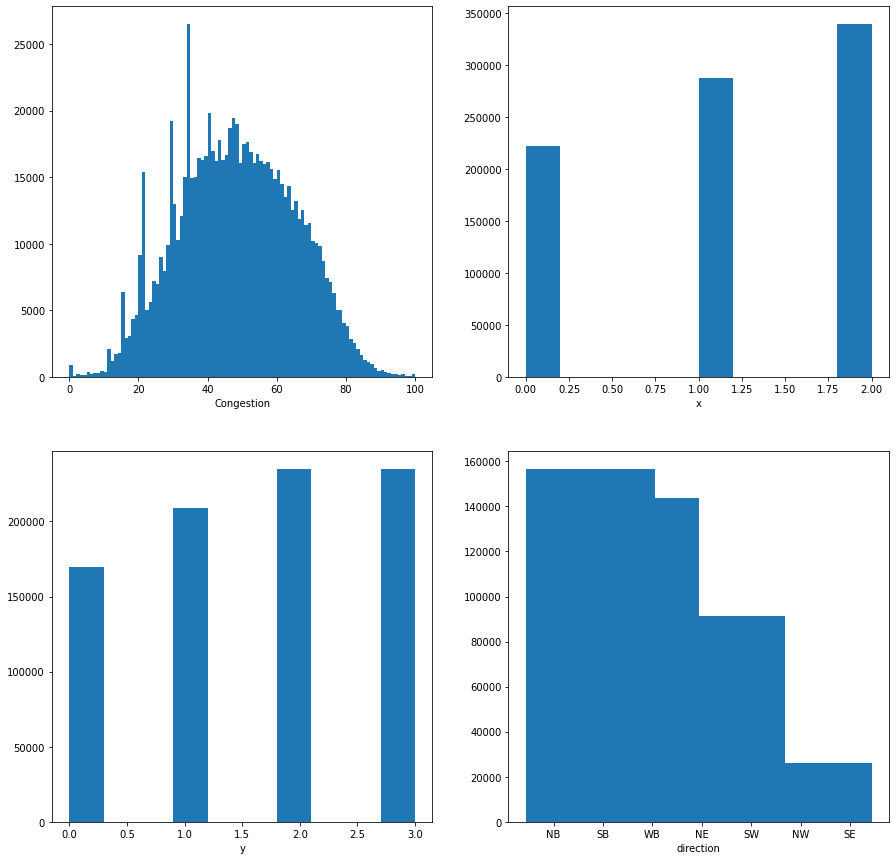

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].hist(df_train['congestion'], bins=100)
ax[0, 0].set_xlabel('Congestion')

ax[0, 1].hist(df_train['x'])
ax[0, 1].set_xlabel('x')

ax[1, 0].hist(df_train['y'])
ax[1, 0].set_xlabel('y')

ax[1,1].hist(df_train['direction'], bins=df_train['direction'].nunique(), align='right')
ax[1, 1].set_xlabel('direction')

fig.show()

# TODO
* Reweighting of congestion (target)?

In [6]:
# adding month and day features
df_train['day']   = df_train['time'].dt.dayofweek
df_train['month'] = df_train['time'].dt.month

In [7]:
print(df_train['day'].value_counts())
print(df_train['month'].value_counts())

0    124020
6    121680
4    121290
1    121225
2    121095
5    119925
3    119600
Name: day, dtype: int64
7    144885
5    144560
8    143650
6    140140
4    139880
9    135720
Name: month, dtype: int64


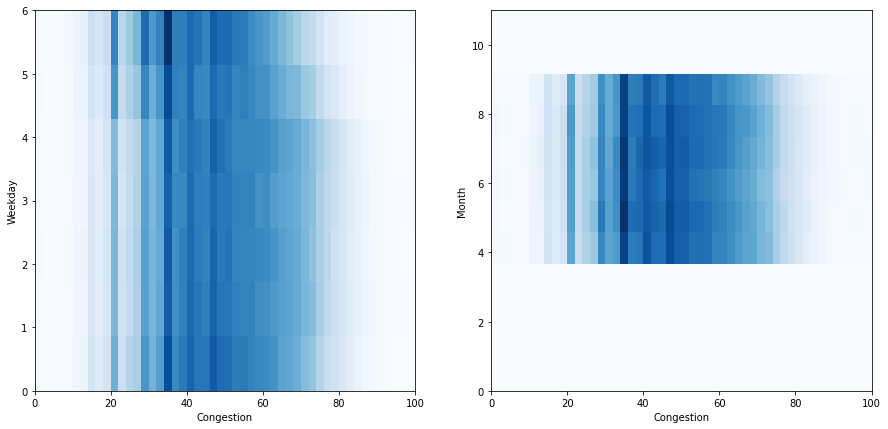

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].hist2d(df_train['congestion'], df_train['day'], bins = [50, 7], cmap=mpl.cm.Blues)
ax[0].set_xlabel('Congestion')
ax[0].set_ylabel('Weekday')

ax[1].hist2d(df_train['congestion'], df_train['month'], bins = [50, 12], cmap=mpl.cm.Blues, range=([0, 100], [0, 11]))
ax[1].set_xlabel('Congestion')
ax[1].set_ylabel('Month')

plt.show()

# Where do the congestion spikes come from?

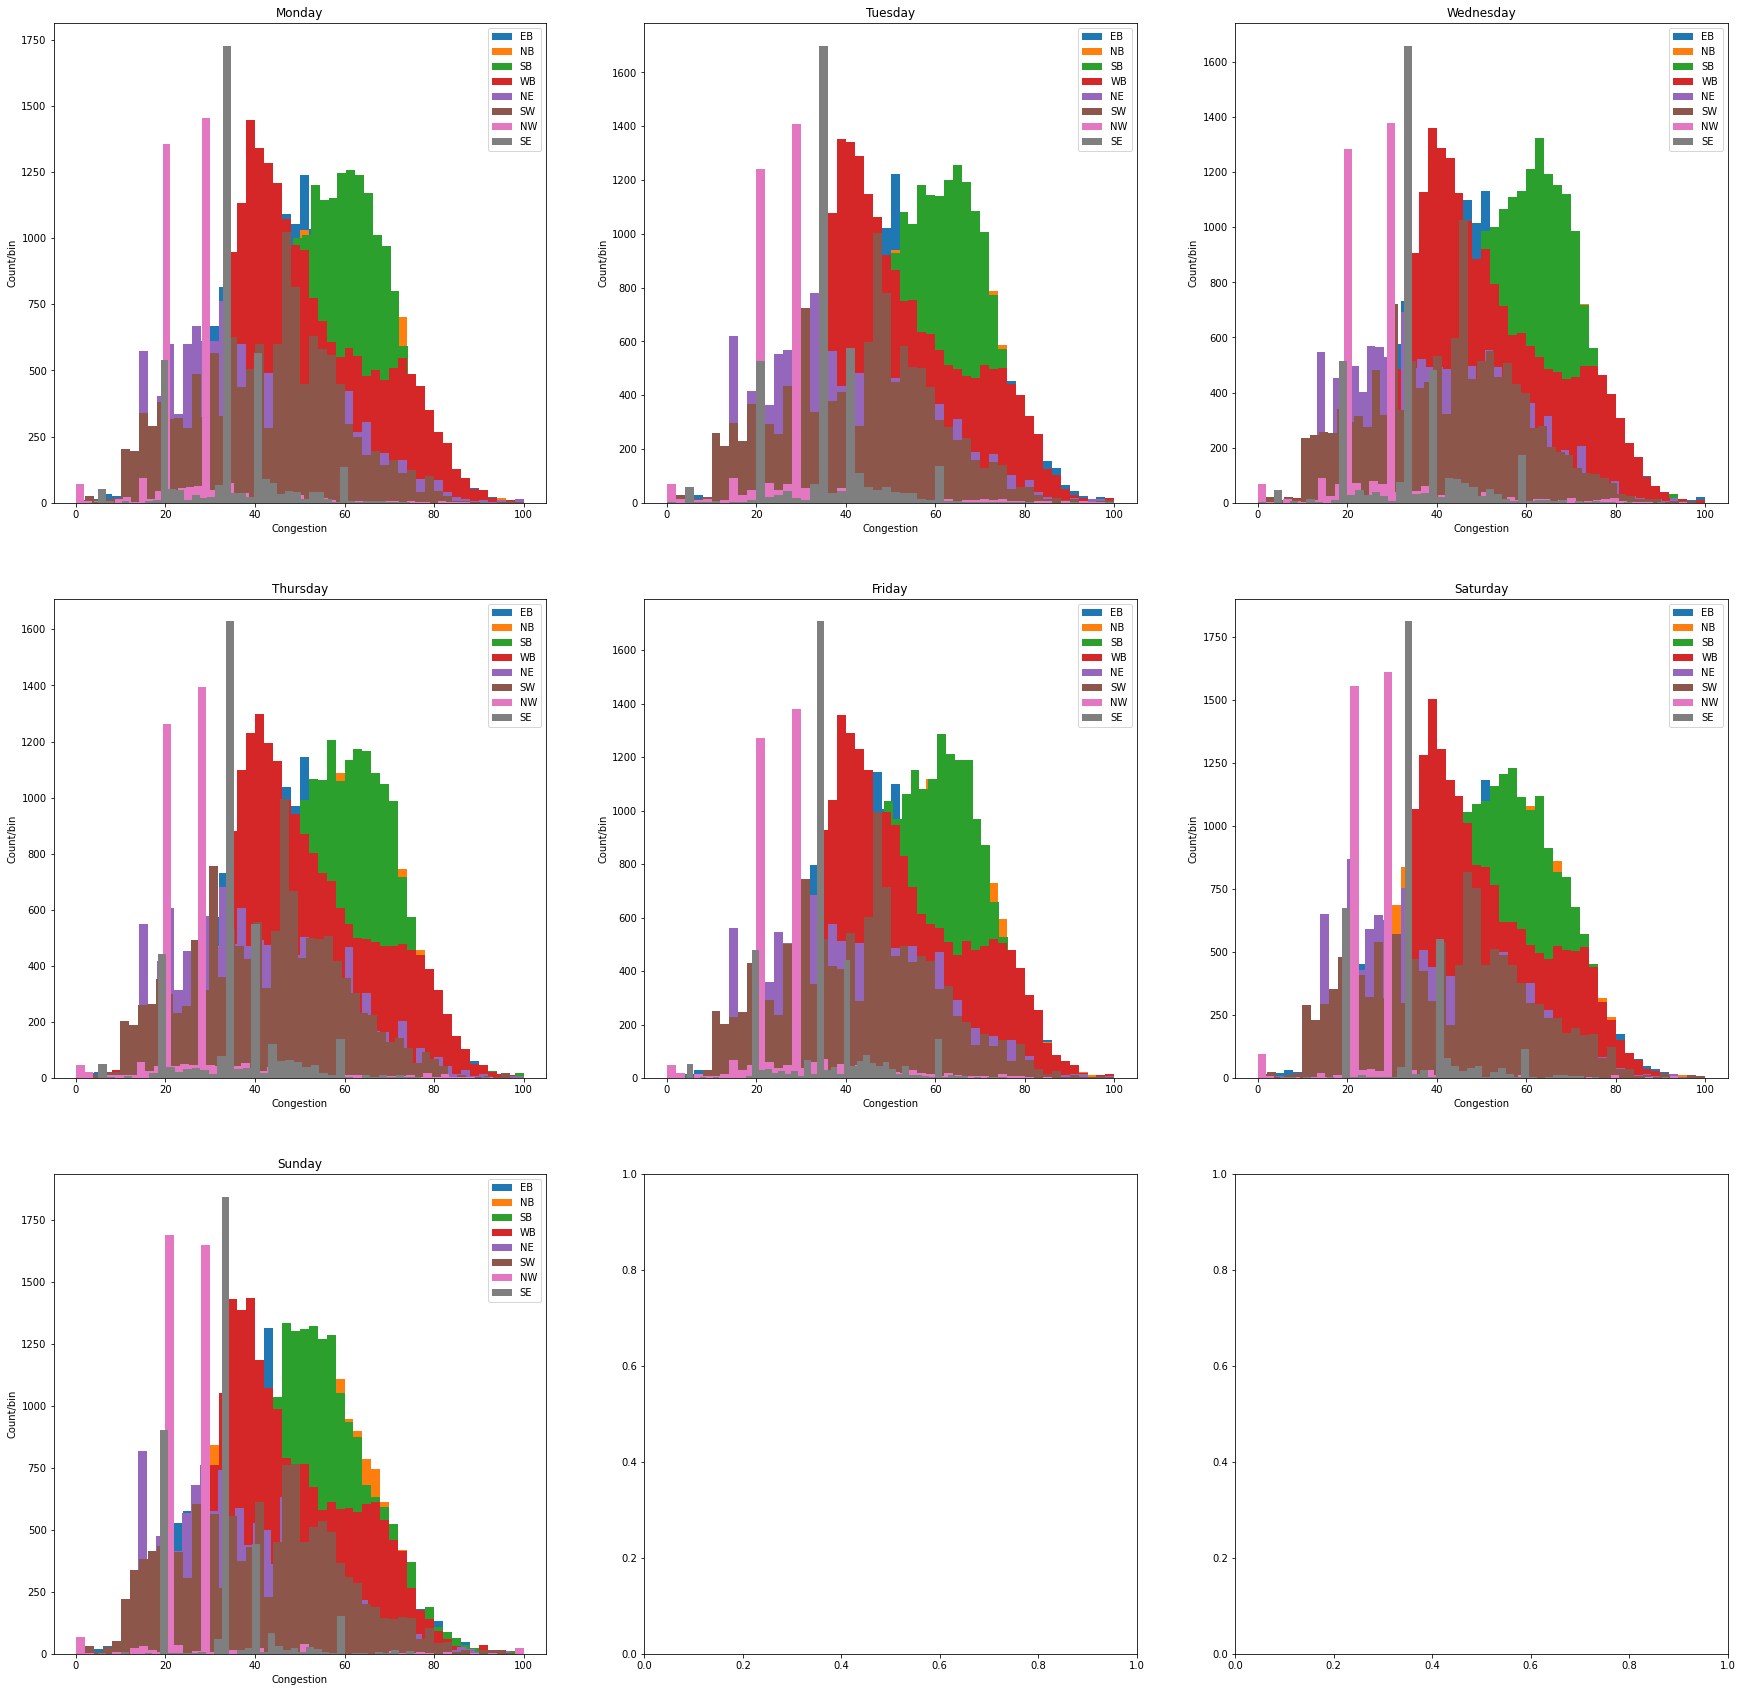

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
unique_directions = df_train['direction'].unique()

title_map = {
    0 : 'Monday',
    1 : 'Tuesday',
    2 : 'Wednesday',
    3 : 'Thursday',
    4 : 'Friday',
    5 : 'Saturday',
    6 : 'Sunday',
}

ax = ax.ravel()
for i in range(7):
    day_view = df_train[df_train['day'] == i]
    for direction in unique_directions:
        direction_view = day_view[day_view['direction'] == direction]
        ax[i].hist(direction_view['congestion'], label=direction, bins=50, stacked=True)
    ax[i].legend(loc='best')
    ax[i].set_xlabel('Congestion')
    ax[i].set_ylabel('Count/bin')
    ax[i].set_title(title_map[i])
ax = ax.reshape(3, 3)
plt.show()

* Spikes are limited to NW and SE traffic?
* What is special about these values?
* The day of week and travel direction already seem like a good enough grouping to form sensible predictions of congestion
* Try submitting the mean of these groupings

In [10]:
"""import holidays
holiday_list = holidays.US()
def is_holiday(x):
    return int(x in holiday_list)
df_train['national_holiday'] = df_train['time'].apply(is_holiday)"""

"import holidays\nholiday_list = holidays.US()\ndef is_holiday(x):\n    return int(x in holiday_list)\ndf_train['national_holiday'] = df_train['time'].apply(is_holiday)"

In [11]:
"""fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(df_train.corr(), cmap=sns.color_palette("vlag", as_cmap=True), square=True, ax=ax, annot=True)
plt.show()"""

'fig, ax = plt.subplots(1, 1, figsize=(10, 10))\nsns.heatmap(df_train.corr(), cmap=sns.color_palette("vlag", as_cmap=True), square=True, ax=ax, annot=True)\nplt.show()'

# Congestion probably also has a high correlation with time of day, let's check

In [12]:
df_train['hour'] = df_train['time'].dt.hour

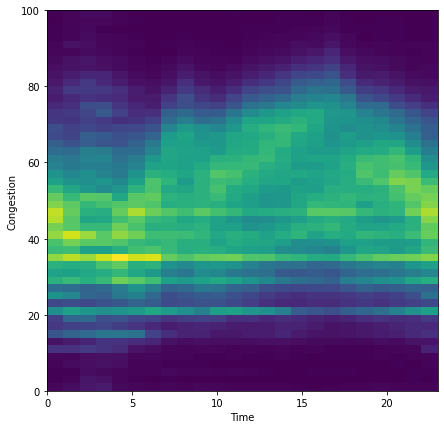

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
#ax.plot(day_view['time'], day_view['congestion'])
#ax.plot(day_view['hour'], day_view['congestion'], 'b*')
ax.hist2d(df_train['hour'], df_train['congestion'], bins=(24, 50))
ax.set_ylabel('Congestion')
ax.set_xlabel('Time')
plt.show()

## naive model, grouping by direction, day of week, hour, and road position (x,y)

In [14]:
naive_model = df_train.groupby(['hour', 'direction', 'x', 'y', 'day']).mean()

In [15]:
print(naive_model)

                        congestion     month
hour direction x y day                      
0    EB        0 0 0     39.555556  6.518519
                   1     38.923077  6.423077
                   2     39.128205  6.461538
                   3     42.205128  6.500000
                   4     39.307692  6.500000
...                            ...       ...
23   WB        2 3 2     40.448718  6.461538
                   3     39.653846  6.500000
                   4     43.435897  6.500000
                   5     44.307692  6.538462
                   6     41.333333  6.576923

[10920 rows x 2 columns]


## Adding features to testing

In [16]:
df_test['time'] = pd.to_datetime(df_test['time'])

df_test['hour']  = df_test['time'].dt.hour
df_test['day']   = df_test['time'].dt.dayofweek
df_test['month'] = df_test['time'].dt.month

In [17]:
list_preds = []
for i in range(len(df_test)):
    row = df_test.iloc[i]
    hour, direction, x, y, day = row['hour'], row['direction'], row['x'], row['y'], row['day']
    
    row_id     = row['row_id']
    prediction = naive_model.loc[hour, direction, x, y, day]['congestion']
    list_preds.append( {'row_id' : row_id, 'congestion' : prediction})
    
predictions = pd.DataFrame(columns=['row_id', 'congestion'])
predictions = predictions.append(list_preds)
predictions['congestion'] = predictions['congestion'].round().astype(int)
print(predictions)

      row_id  congestion
0     848835          46
1     848836          37
2     848837          54
3     848838          26
4     848839          71
...      ...         ...
2335  851170          67
2336  851171          32
2337  851172          70
2338  851173          18
2339  851174          41

[2340 rows x 2 columns]


In [18]:

predictions.to_csv('submission.csv', index=False)